In [56]:
#import packages
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC
import numpy as np
from scipy.stats import binom
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from pandas import DataFrame
import random


# Names and IDs
 1. Etay Lorberboym - 314977596
 2. Peleg Gitnik - 208816827

# I. Condorcet's Jury Theorem (1785)

Assume voter probability to be correct as $p>.5$.

1. Plot the probability a jury of $n$ voters (odd) is correct as a function of $p$ for different $n$ using Monte-Carlo simulations (sampling and averaging).

2. Prove that as number of jury members grows, $n\rightarrow\infty$, the  jury majority becomes correct  $\Pr(\text{correct}) \rightarrow 1$ (**hint**: use the law of large numbers).

Notes: Avoid loops where possible.

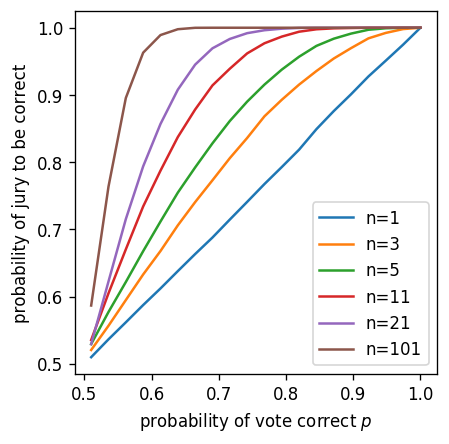

###Answer 1

In [80]:
def calc_jury_prob(n,p):
    sample_size = 500000
    sample = np.random.binomial(n, p, sample_size)
    sample = [i/n for i in sample]
    avg_sample = sum([1 for i in range(len(sample)) if sample[i]>0.5])/sample_size
    return avg_sample

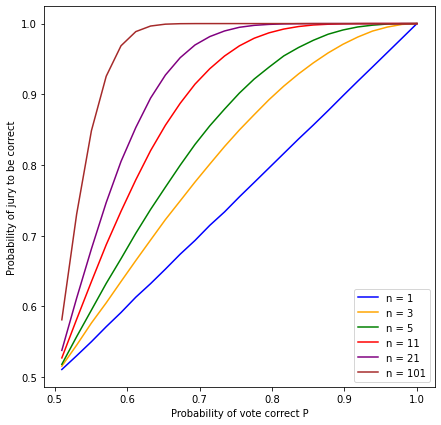

In [82]:
n = [1,3,5,11,21,101]

vote_prob= np.linspace(0.51,1,25)
colors = ['blue','orange','green','red','purple','brown']

fig = plt.figure(figsize= (7,7))
ax = plt.axes()

for i in range(len(n)):
  jury_prob = []
  for p in vote_prob:
    jury_prob.append(calc_jury_prob(n[i], p))
  ax.plot(vote_prob ,jury_prob, colors[i])
  
plt.gca().legend(('n = 1','n = 3','n = 5','n = 11','n = 21','n = 101'))
plt.xlabel('Probability of vote correct P')
plt.ylabel('Probability of jury to be correct')
plt.show()

###Answer 2


First of all we will explain the Condorcet's Jury therom and then we will prove that when number of jury members $n\rightarrow\infty$ the jury majority becomes correct, meaning $\Pr(\text{correct}) \rightarrow 1$ 

<u> **Condorcet's Jury therom:** </u>

We assume we have a population of n voters, where each voter has two option to choose:

+1 or -1 where one of the decisions is "correct".

We will write each voter's vote as $x_i$ and would want to calcualte the the group decision  $X = \sum_{i=1}^n{x_i}$

We would want to check if the result $X$ is postive or negative.

<u>**Proof:** </u>

For the proof we assume all voters are independent of one onother and each voter probabilty of making a correct choise is $p> 0.5$


We will show that when we increse the jury size to $\infty$ the probabilty of the group to take the correct choise will aproach 1.


We will assume the correct choise is +1 without the loss of generality.

let $a = p - 0.5 > 0$ and $1 - a = 1 - (p - 0.5) = 0.5 - p $

the mean will be $ E[X_+] = +1 * ( p - 0.5 ) -1 * (0.5 - p) = 2p - 1 = 2a $

We will use the weak law of large numbers  $lim_{n\to\infty} P(|\bar{X}- {E[X_+]} | < {\epsilon})=1$ to show that $\bar{X}$ convarges in probability  to $ E[X_+]$ where $n\rightarrow\infty$.

When we take $ \epsilon = 2a$ we can see that the probabilty for a correct choise we be:


$P(X >0) = P(\bar{X} > 0) \ge lim_{n\to\infty} P(|\bar{X}- 2a | < 2a)=1 $





# II. AdaBoost
* Use `AdaBoostClassifier` model from sklearn.ensemble to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` from sklearn.svm) with the next parameters:
        - *tol=1e-10,loss='hinge', C=1000, max_iter=50000*
    - Split the sample set into 2/3rd train set and 1/3 test set.
    - Train ensemble classifiers where each has a different number of estimators $n\in \{1, 3, 10, 50, 100, 1000, 10000\}$.
    - Use the given function plot_data or your own function to plot the final decision plane of each ensemble model.

* Answer to the next questions:

 1. How does the overall train set accuracy change with $n$?
 2. Does your model start to overfit at some point? How can you test and detect such a point?
 3. For this specific task, what is the optimal number of estimators? Hint: use `estimator_errors_` attribute.

 ---
 **Note1:** 
 1. If ***linearSVC*** doesn't work, you can use ***SVC*** with: `kernel='linear'` and `probability=True`.
 2. Explain you results in text and support it with figures.

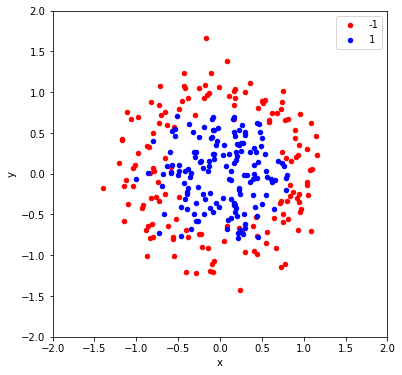

In [59]:

# generate 2d classification dataset
X, y = make_circles(n_samples=300, noise=0.2, random_state=101, factor=0.5)
y = y*2 - 1
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(6,6))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [60]:
def plot_data(X, y, h, ax):
    '''Plotting function. The function will plot the given instances as well will color the
    background according to the decision boundaries of the model.
    X - 2D array
    y - Vector of labels
    h - A function which accepts X and returns the predicted labels. It should be based on the trained model.
    ax - axes.Axes object as returned by matplotlib.pyplot.subplots function.'''
    def make_meshgrid(x, y, h=.01):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        return xx, yy
  
    def plot_contours(ax, clf, xx, yy, **params):
        Z = h(np.c_[xx.ravel(), yy.ravel()])  # predictions
        Z = Z.reshape(xx.shape)
        if 'levels' in params and len(params['levels'])<2:
          out = ax.contour(xx, yy, Z, **params, colors='k', edgesize=10)
        else:
          out = ax.contourf(xx, yy, Z, **params)
        return out
  
    # scatter plot, dots colored by class value
    df = DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))
    colors = {-1:'red', 1:'blue'}
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x0', y='x1', 
                 alpha=0.5, label=key, color=colors[key])
  
    # decision boundary
    xx1, xx2 = make_meshgrid(X[:,0], X[:,1])
    plot_contours(ax, h, xx1, xx2, alpha=0.2)#, levels=[0.5])
  
    ax.axis('scaled')

#### Answer


In [61]:
# split into train test sets into 2/3 train size and 1/3 test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state = 314977596)

lsvc = LinearSVC(tol=1e-10,loss='hinge', C=1000, max_iter=50000)

n = [1,3,10,50,100,1000,10000]
models = []

for curr_size in n:
  # Create adaboost classifer object with current size of n.
  abc = AdaBoostClassifier(base_estimator = lsvc,n_estimators = curr_size,algorithm='SAMME')
  # Train Adaboost Classifer 
  curr_model = abc.fit(X_train, y_train)
  models.append(curr_model)

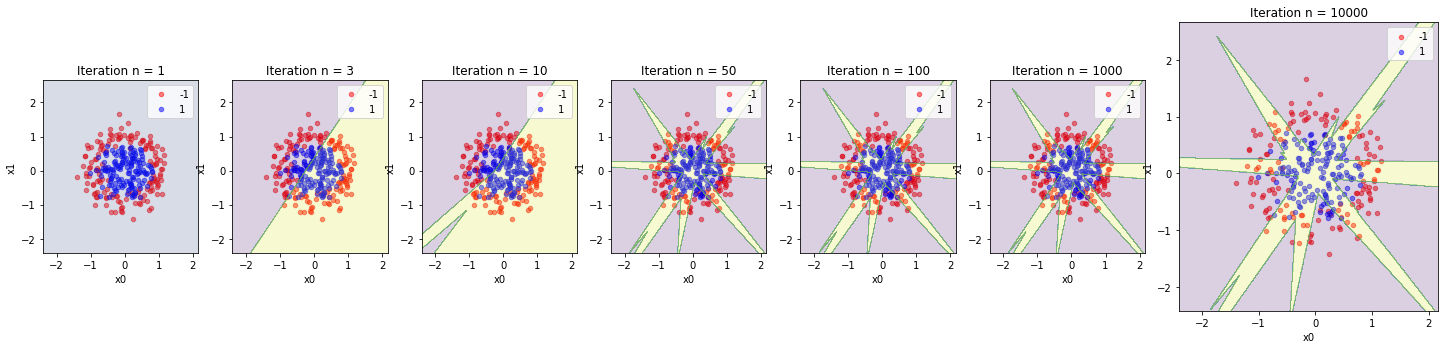

In [62]:
fig,ax = plt.subplots(1,7, figsize = (25,25), gridspec_kw={'width_ratios':[3,3,3,3,3,3,5]})

for i in range(len(n)):
  plot_data(X,y,models[i].predict,ax[i])
  ax[i].set_title('Iteration n = {}'.format(n[i]))

**1. Explanation of Accuracy change:**    



First of all, we would like to calculate the accuracy rate for each number of estimators (n).

In [63]:

accuracies_train = []
# Calculating accuracy score for train set:
for m in models:
  y_pred_train = m.predict(X_train)
  accuracies_train.append(accuracy_score(y_train, y_pred_train))

# Printing the train set accuracy level for each n:
print("Accuracy scores of train set:")
for i in range(len(n)):
  print('Model with n = {} recieved accuracy level of: {}'.format(n[i], np.round(accuracies_train[i],3)))

Accuracy scores of train set:
Model with n = 1 recieved accuracy level of: 0.542
Model with n = 3 recieved accuracy level of: 0.612
Model with n = 10 recieved accuracy level of: 0.597
Model with n = 50 recieved accuracy level of: 0.716
Model with n = 100 recieved accuracy level of: 0.716
Model with n = 1000 recieved accuracy level of: 0.716
Model with n = 10000 recieved accuracy level of: 0.716


<u>Explanation: </u>


As we can see, while we increase the number of estimators in our ensemble model we recieve better accuracy score, until we reach a point where we get the same accuray level for models with higher number of estimators.
When we run the model with $n = 10$ number of estimators the accuracy level droped by 2%, but right after when we increase the number of estimators our model accuracy has improved.
The number of estimators where the model accuracy stays the same is when we use $n \ge 50$ estimators for the model.

**2.Overfit of the model:**

To check if there is an overfit, we will check the accuracy score for each $n$ of test and train sets (and their differences):

In [64]:
from tabulate import tabulate

accuracies_test = []
# Calculating accuracy score for test set:
for m in models:
  y_pred = m.predict(X_test)
  accuracies_test.append(accuracy_score(y_test, y_pred))

# Accuracy score of test and train sets:
print(tabulate([[n[i], np.round(accuracies_test[i], 3), np.round(accuracies_train[i], 3),np.round(accuracies_train[i], 3) - np.round(accuracies_test[i], 3)] for i in range(len(models))], headers=['n', 'Test', 'Train', 'Diff (Train - Test)']))

    n    Test    Train    Diff (Train - Test)
-----  ------  -------  ---------------------
    1   0.414    0.542                  0.128
    3   0.515    0.612                  0.097
   10   0.505    0.597                  0.092
   50   0.687    0.716                  0.029
  100   0.687    0.716                  0.029
 1000   0.687    0.716                  0.029
10000   0.687    0.716                  0.029


We would like to plot the accury level of the model with an increasing $n$ for a better visualization and understanding.

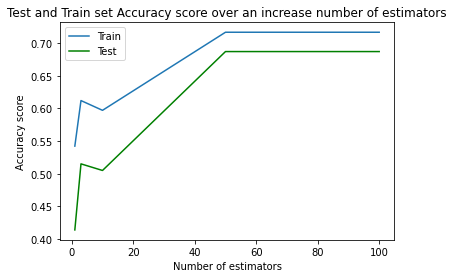

In [65]:
# Plotting the accuracies scores of Test and Train sets:
plt.plot(n[:5], accuracies_train[:5], label = 'Train')
plt.plot(n[:5], accuracies_test[:5], label = 'Test', color = 'Green')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy score')
plt.title('Test and Train set Accuracy score over an increase number of estimators')
plt.legend()

plt.show()

As we can see from the plot and the difference table the model **do not tend to overfit**.

<u> Explanation: </u>

As we studied in class a model tend to overfit when the model learn the data too well resulting high accuracy score of the training data and low accuracy score for the test data.

In our model we can see from the plot that there is no big enough difffence of the accuracies score between the train and test data (maximun diffrence of 13%), also the trainig set accuracy level didnt recieved too good score (maximum of 71.6%).

Our assumption is that AdaBoost model is robust to overfitting because we use a combination of weak learners (linear svc models for each AdaBoost model).

If we would want to ensure our model is not overfitting we would use a k-fold cross - valudation.


Another way to look at in is by checking the error rate (which is 1 - accuracy) and see that the model is not overfitted.

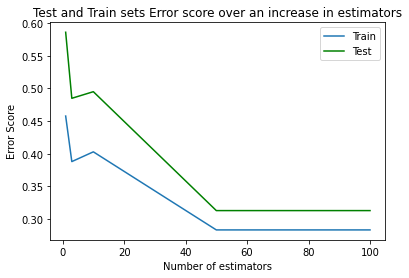

In [66]:
# Error score of test and train sets:
error_test = [1-i for i in accuracies_test]
error_train = [1-i for i in accuracies_train]

# Plotting the accuracies scores of Test and Train sets:
plt.plot(n[:5], error_train[:5], label = 'Train')
plt.plot(n[:5], error_test[:5], label = 'Test', color = 'Green')
plt.xlabel('Number of estimators')
plt.ylabel('Error Score')
plt.title('Test and Train sets Error score over an increase in estimators')
plt.legend()

plt.show()

Same as we said with the accuracy comparsion the error rate of both the train and test data decrease and the same rate and stop decreasing at the same level, meaning no overfitting.

**3. Optimal number of estimators:**    


We will use the `estimator_errors_` attribute (returns classification error for each estimator in the boosted ensemble) to calculate the number of correct estimators(the estimators that didnt recieved and error of 100% for each $n$).

In [67]:
for i in range(len(models)):
  num_correct_estimators = len(models[i].estimator_errors_[models[i].estimator_errors_ < 1])
  print('Correct estimators for model with n = {} is {} '.format(n[i],num_correct_estimators))

Correct estimators for model with n = 1 is 1 
Correct estimators for model with n = 3 is 3 
Correct estimators for model with n = 10 is 10 
Correct estimators for model with n = 50 is 42 
Correct estimators for model with n = 100 is 42 
Correct estimators for model with n = 1000 is 42 
Correct estimators for model with n = 10000 is 42 


We would want to plot the results to find the optimal number of estimators.

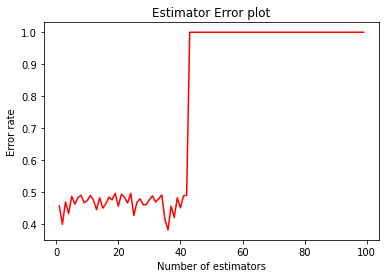

In [68]:
# We will plot the Estimation Errors plot (trying with estimator number of 50):
x_num_estimators = [i for i in range(1, 100)]

error = models[4].estimator_errors_
y_error = [error[i] for i in range(99)]

plt.plot(x_num_estimators, y_error, color = "Red")
plt.xlabel('Number of estimators')
plt.ylabel('Error rate')
plt.title('Estimator Error plot')

plt.show()

<U>Explanation: </u>

The number of optimal estimators will be the point when we get to misclassification (the point where the error of the next estimator is 100%).

We can see that the error rate is staying below 50% for each estimator as the number of estimators increases until we reach $42$ estimators.

So we can say that the optimal amount of estimators is $42$ estimators.

Reaching this point where the AdaBoost algorithm stops improving might be because one of the stopping conditions for the base estimator of the SAMME algorithm has occured.

